In [0]:
# Education - Udacity "Intro to TensorFlow for Deep Learning"
# Module: Forecasting with Recurrent Neural Network (Sequence to Vector) and (Sequence to Sequence)
# REF: https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c06_forecasting_with_rnn.ipynb

In [2]:
# Import packages.
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import matplotlib.pyplot as plt

# Using version 2.x of Tensorflow.
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

# Tensorflow.
import tensorflow as tf

# Print Tensorflow version.
print('TensorFlow Version:', tf.__version__)

TensorFlow 2.x selected.
TensorFlow Version: 2.1.0


In [0]:
# ====================
# Helper Function
# ====================
# Plot serie.
def plot_series(time, series, format="-", start=0, end=None, label=None):
  plt.plot(time[start:end], series[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("Value")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)


# Trend.
def trend(time, slope=0):
  return slope * time


# Seasonal pattern.
def seasonal_pattern(season_time):
  # Just an arbitrary pattern.
  return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi), 1 / np.exp(3 * season_time))


# Seasonality.
def seasonality(time, period, amplitude=1, phase=0):
  # Repeats the same pattern at each period.
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)


# White noise.
def white_noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level


# Simple window dataset.
def window_dataset(series, window_size, batch_size = 32, shuffle_buffer = 1000):
  # Create a dataset of tensors.
  dataset = tf.data.Dataset.from_tensor_slices(series)

  # Drop remaining values so we get same size.
  dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)

  # The dataset contains a tensor with size of 5.
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

  # Split into two arrays, one for inputs and one for labels.
  dataset = dataset.map(lambda window: (window[ : -1], window[-1 : ]))

  # Shuffle the dataset.
  dataset = dataset.shuffle(shuffle_buffer)

  # Create batches. The 'prefetch' indicates the Tensorflow will
  # fetch the data while working, so we always have data to use.
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset


# Sequence to sequence dataset.
def seq2seq_window_dataset(series, window_size, batch_size = 32, shuffle_buffer = 1000):
  series = tf.expand_dims(series, axis = -1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift = 1, drop_remainder = True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[1:]))
  return ds.batch(batch_size).prefetch(1)


# Predict function.
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

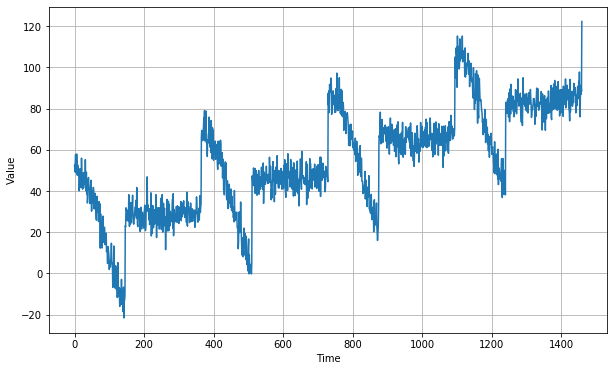

In [4]:
# Create dataset.
time      = np.arange(4 * 365 + 1)
slope     = 0.05
baseline  = 10
amplitude = 40
series    = baseline + trend(time, slope) + seasonality(time, period = 365, amplitude = amplitude)

noise_level = 5
noise       = white_noise(time, noise_level, seed = 42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [0]:
# Prepare for machine learning.
split_time    = 1000
time_train    = time[:split_time]
series_train  = series[:split_time]
time_valid    = time[split_time:]
series_valid  = series[split_time:]

SEED        = 42
WINDOW_SIZE = 30

In [6]:
# ==================
# RNN Forecasting (Sequence to Vector)
# ==================
tf.keras.backend.clear_session()
tf.random.set_seed(SEED)
np.random.seed(SEED)

vec_dataset_train = window_dataset(series_train, WINDOW_SIZE, batch_size = 128)
vec_dataset_valid = window_dataset(series_valid, WINDOW_SIZE, batch_size = 128)

vec_model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1), input_shape = [None]),
  tf.keras.layers.SimpleRNN(100, return_sequences = True),
  tf.keras.layers.SimpleRNN(100),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200.0)
])

vec_model.compile(
  loss = tf.keras.losses.Huber(),
  optimizer = tf.keras.optimizers.SGD(lr = 1.5e-6, momentum = 0.9),
  metrics = ["mae"]
)

vec_early_stopping = tf.keras.callbacks.EarlyStopping(patience = 50)
vec_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "seqvec_checkpoint.h5",
    save_best_only = True
)

vec_model.fit(
  vec_dataset_train,
  epochs = 500,
  validation_data = vec_dataset_valid,
  callbacks = [vec_early_stopping, vec_model_checkpoint]
)

vec_model = tf.keras.models.load_model("seqvec_checkpoint.h5")

vec_rnn = model_forecast(
    vec_model,
    series[split_time - WINDOW_SIZE: - 1],
    WINDOW_SIZE
)[:, 0]

Epoch 1/500
8/8 [==============================] - 3s 408ms/step - loss: 59.3020 - mae: 60.3561 - val_loss: 42.0142 - val_mae: 42.3809
Epoch 2/500
8/8 [==============================] - 1s 64ms/step - loss: 36.5803 - mae: 37.3106 - val_loss: 11.4775 - val_mae: 11.7886
Epoch 3/500
8/8 [==============================] - 1s 63ms/step - loss: 23.6567 - mae: 24.0715 - val_loss: 12.7571 - val_mae: 13.0818
Epoch 4/500
8/8 [==============================] - 1s 63ms/step - loss: 16.7817 - mae: 17.6512 - val_loss: 21.4763 - val_mae: 22.3445
Epoch 5/500
8/8 [==============================] - 0s 61ms/step - loss: 13.7011 - mae: 14.3757 - val_loss: 10.0938 - val_mae: 10.6566
Epoch 6/500
8/8 [==============================] - 0s 60ms/step - loss: 11.4010 - mae: 12.0649 - val_loss: 11.5668 - val_mae: 12.0477
Epoch 7/500
8/8 [==============================] - 0s 62ms/step - loss: 11.0705 - mae: 11.4645 - val_loss: 8.4023 - val_mae: 8.9583
Epoch 8/500
8/8 [==============================] - 1s 69ms/step

In [7]:
# ==================
# RNN Forecasting (Sequence to Sequence)
# ==================
tf.keras.backend.clear_session()
tf.random.set_seed(SEED)
np.random.seed(SEED)

seq_dataset_train = seq2seq_window_dataset(series_train, WINDOW_SIZE, batch_size = 128)
seq_dataset_valid = seq2seq_window_dataset(series_valid, WINDOW_SIZE, batch_size = 128)

seq_model = tf.keras.models.Sequential([
  tf.keras.layers.SimpleRNN(100, return_sequences = True, input_shape = [None, 1]),
  tf.keras.layers.SimpleRNN(100, return_sequences = True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200.0)
])

seq_model.compile(
  loss = tf.keras.losses.Huber(),
  optimizer = tf.keras.optimizers.SGD(lr = 1e-6, momentum = 0.9),
  metrics = ["mae"]
)

seq_early_stopping = tf.keras.callbacks.EarlyStopping(patience = 10)
seq_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "seqseq_checkpoint.h5",
    save_best_only = True
)

seq_model.fit(
  seq_dataset_train,
  epochs = 500,
  validation_data = seq_dataset_valid,
  callbacks = [seq_early_stopping, seq_model_checkpoint]
)

seq_model = tf.keras.models.load_model("seqseq_checkpoint.h5")

seq_rnn = model_forecast(
    seq_model,
    series[..., np.newaxis],
    WINDOW_SIZE
)
seq_rnn = seq_rnn[split_time - WINDOW_SIZE:-1, -1, 0]

Epoch 1/500
8/8 [==============================] - 2s 246ms/step - loss: 55.8513 - mae: 56.2826 - val_loss: 17.6785 - val_mae: 18.0197
Epoch 2/500
8/8 [==============================] - 1s 77ms/step - loss: 33.9155 - mae: 35.1114 - val_loss: 17.4471 - val_mae: 18.0774
Epoch 3/500
8/8 [==============================] - 1s 80ms/step - loss: 28.3637 - mae: 28.6514 - val_loss: 35.8526 - val_mae: 36.0964
Epoch 4/500
8/8 [==============================] - 1s 77ms/step - loss: 21.0046 - mae: 21.6919 - val_loss: 27.8289 - val_mae: 28.4824
Epoch 5/500
8/8 [==============================] - 1s 71ms/step - loss: 17.9119 - mae: 18.5032 - val_loss: 17.8702 - val_mae: 18.4260
Epoch 6/500
8/8 [==============================] - 1s 79ms/step - loss: 15.3045 - mae: 15.8192 - val_loss: 10.6282 - val_mae: 11.1624
Epoch 7/500
8/8 [==============================] - 1s 74ms/step - loss: 13.8782 - mae: 14.3735 - val_loss: 8.7739 - val_mae: 9.2796
Epoch 8/500
8/8 [==============================] - 1s 67ms/step

MAE: (Seq2Vec: 5.4141636) vs (Seq2Seq: 5.0920377)


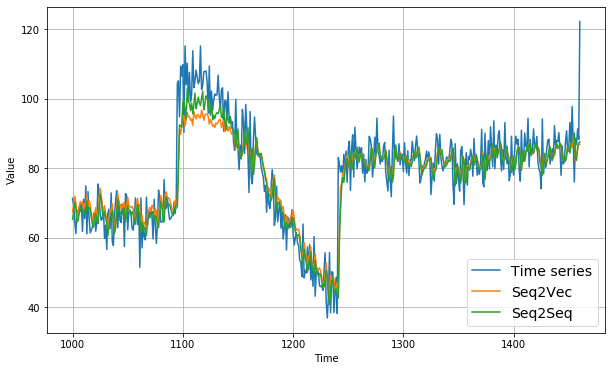

In [8]:
# Plot the forecasts.
plt.figure(figsize = (10, 6))
plot_series(time_valid, series_valid, label = "Time series")
plot_series(time_valid, vec_rnn, label = "Seq2Vec")
plot_series(time_valid, seq_rnn, label = "Seq2Seq")

vec_mae = tf.keras.metrics.mean_absolute_error(series_valid, vec_rnn).numpy()
seq_mae = tf.keras.metrics.mean_absolute_error(series_valid, seq_rnn).numpy()
print("MAE: (Seq2Vec: " + str(vec_mae) + ") vs (Seq2Seq: " + str(seq_mae) + ")")